# Importa bibliotecas

In [1]:
import os
path = os.path.abspath('')
# print(path)
items = os.listdir(path)
if 'Funcoes_GETS.py' not in items:
    ! jupyter nbconvert --to 'python' Funcoes_GETS.ipynb
import Funcoes_GETS as fg

import pandas as pd
import numpy as np
import ipywidgets as widgets
from bqplot import pyplot as bqplt
import bqplot as bq
%matplotlib notebook 

# Carrega banco de dados

In [2]:
equips_data = fg.get_all_equips_data()
OS_data = fg.get_all_OS_data()
OS_data = OS_data.dropna(subset=['Tipo Equip.'])
material_cost_data = fg.load_material_cost_data()
external_cost_data = fg.load_external_cost_data()
# equip_type = np.sort(equips_data['Tipo Equipamento'].unique())
equip_type = np.sort(equips_data['Tipo Equipamento'].unique())

# Gera interface

In [3]:
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [115]:
'''###########################
   ####Update data to plot####
   ###########################'''
def update_data(equip,start_date,end_date):
    import pandas as pd
    import numpy as np
    from datetime import date
    today = pd.to_datetime(date.today()).to_numpy()
    if len(equip)==1:
        equip = equip[0]
    available_equips, equip_amount_data, break_data = fg.get_available_equip(equip,equips_data,OS_data)
#     global break_data
#     break_data = breaks
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    x_data1,y_data1,x_data2,y_data2 = fg.arrange_equip_data_to_plot(available_equips,equip_amount_data,start_date,end_date)
    #arrange break_data the same way
    #create time series for break_data
    break_ts = pd.Series(break_data['Taxa de Quebra'].values, index=break_data.index.get_level_values(0))
    #insert last datapoint as today, replicating last known value
    break_ts = break_ts.append(pd.Series(break_ts[-1], index=[today]))
    
    
    #Checks for empty data (necessary to adjust y axis limits)
    empty_flag1,between_two_dates1 = fg.check_for_empty_data(equip_amount_data,start_date,end_date)
    empty_flag2,between_two_dates2 = fg.check_for_empty_data(available_equips,start_date,end_date)
    if empty_flag2==False:
        ymin = np.amin(available_equips[between_two_dates2]['Quantidade Disponível'].values.astype(int))
    else:
        ymin = 0
    if empty_flag1==False:
        ymax = np.amax(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
    else:
        ymax = np.amax(equip_amount_data['Quantidade de Equipamentos'].values.astype(int))
    return(x_data1,y_data1,x_data2,y_data2,ymin,ymax, break_ts)

def update_data2(equip,start_date,end_date):
    import pandas as pd
    from datetime import date
    today = pd.to_datetime(date.today()).to_numpy()
    if len(equip)==1:
        equip = equip[0]

    available_equips, equip_amount_data, break_data = fg.get_available_equip(equip,equips_data,OS_data)

    material_monthly_cost = fg.get_equip_monthly_cost(equip,material_cost_data)
    external_monthly_cost = fg.get_equip_monthly_cost(equip,external_cost_data)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    x_data1,y_data1,x_data2,y_data2,x_data3,y_data3 = fg.arrange_cost_data_to_plot(material_monthly_cost,external_monthly_cost,equip_amount_data,start_date,end_date)
    #arrange break_data the same way
    #create time series for break_data
    break_ts = pd.Series(break_data['Taxa de Quebra'].values, index=break_data.index.get_level_values(0))
    #insert last datapoint as today, replicating last known value
    break_ts = break_ts.append(pd.Series(break_ts[-1], index=[today]))
    #Checks for empty data (necessary to adjust y axis limits)
    empty_flag1,between_two_dates1 = fg.check_for_empty_data(equip_amount_data,start_date,end_date)
    empty_flag2,between_two_dates2 = fg.check_for_empty_data(material_monthly_cost,start_date,end_date)
    empty_flag3,between_two_dates3 = fg.check_for_empty_data(external_monthly_cost,start_date,end_date)
    
    if empty_flag1==False:
        ymin = np.amin(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
        ymax = np.amax(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
    else:
        ymin = 0
        ymax = np.amax(equip_amount_data['Quantidade de Equipamentos'].values.astype(int))
    
    if selected_analysis.value==1:
        if empty_flag2==False:
            ymax2 = np.amax(material_monthly_cost[between_two_dates2].values)
        else:
            ymax2 = 1
    elif selected_analysis.value==2:
        if empty_flag3==False:
            ymax2 = np.amax(external_monthly_cost[between_two_dates3].values)
        else:
            ymax2 = 1
    else:
        if empty_flag2==False:
            if empty_flag3==False:
                # matches lenghts of x_data2 with x_data3 (add missing dates in x_data and add zeros in missing y_data) 
                i=0
                while x_data3[i] < x_data2[i]:
                    x_data2 = np.insert(x_data2,i,x_data3[i])
                    y_data2 = np.insert(y_data2,0,0)
                    i+=1
                i=0
                while x_data2[i] < x_data3[i]:
                    x_data3 = np.insert(x_data3,i,x_data2[i])
                    y_data3 = np.insert(y_data3,0,0)
                    i+=1
                if len(x_data2)>len(x_data3):
                    y_data3 = np.append(y_data3,np.zeros(len(x_data2)-len(x_data3)))
                    x_data3 = np.append(x_data3,x_data2[len(x_data3):])
                    x_data3 = pd.to_datetime(x_data3)
                elif len(x_data2)<len(x_data3):
                    y_data2 = np.append(y_data2,np.zeros(len(x_data3)-len(x_data2)))
                    x_data2 = np.append(x_data2,x_data3[len(x_data2):])
                    x_data2 = pd.to_datetime(x_data2)
                
                ymax2 = np.amax(np.concatenate((material_monthly_cost[between_two_dates2].values,
                                               external_monthly_cost[between_two_dates3].values)))
            else:
                ymax2 = np.amax(material_monthly_cost[between_two_dates2].values)
        else:
            if empty_flag3==False:
                 ymax2 = np.amax(external_monthly_cost[between_two_dates3].values)
            else:
                ymax2 = 1
    
    
    return(x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts)

'''###########################
   #######Create widgets######
   ###########################'''
title = widgets.Label(value="Interface de Análise Temporal do GETS",
                      layout=widgets.Layout(border= '2px solid black',width='100%', display='flex', align_items='center',
                                           justify_content='center'))
tab_titles = ['Quantidade','Custo']
tab = widgets.Tab()
[tab.set_title(i, title) for i, title in enumerate(tab_titles)]
fig = bq.Figure(axes=[])
x_dt = bq.DateScale()
y_sc1 = bq.LinearScale()
def_tt = bq.Tooltip(fields=['x', 'y'], formats=['%d-%b-%y', 'd'],labels=['Data','Quant.'])
scatter1 = bqplt.scatter(x=np.array([0,1]),y=np.array([0,1]),colors=['#ff77ff00'], stroke_width=1, display_legend=False,
                                      scales={'x': x_dt, 'y': y_sc1}, tooltip=def_tt)
scatter2 = bq.Scatter(x=np.array([0,1]),y=np.array([0,1]),colors=['#ff77ff00'], stroke_width=1, display_legend=False,
                                  scales={'x': x_dt, 'y': y_sc1}, tooltip=def_tt)
interp = 'linear'
line1 = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, labels=['Ativo'],
                             interpolation=interp, colors=['steelblue'])
line2 = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, 
                             labels=['Disponivel'],interpolation=interp, colors=['coral'])
ax_x = bq.Axis(scale=x_dt, label='Data', 
                          tick_style={'stroke': 'black', 'font-size': 12}, tick_format="%b %Y", num_ticks=8)
ax_y1 = bq.Axis(scale=y_sc1, orientation='vertical', label='Quantidade de Equipamentos', 
                           label_style={'stroke': 'black', 'font-size': 12},
                           tick_style={'stroke': 'black', 'font-size': 12},grid_lines='none')
line_forecast = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, labels=['Tendência'],
                             interpolation=interp, colors=['darkred'])
line_conf_int = bq.Lines(x=np.array([0,1]),y=[np.array([0,1]),np.array([0,1])],scales={'x': x_dt, 'y': y_sc1}, 
                         display_legend=False, labels=['IC95%','None'],
                         interpolation=interp, colors=['darkred'], fill='between',fill_opacities=[0.2],stroke_width=0)
# print(line_conf_int)
buttonWidth = '60px'
save_data_button = widgets.Button(
    description = 'save',
    tooltip='Save current data',
    icon = 'fa-file-excel-o'
)
save_data_button.layout.width = '90px'
save_button = widgets.Button(
    description = 'Save',
    button_style='success'
)

save_fig_button= widgets.Button(
    description = 'save',
    tooltip='Save current figure',
    icon = 'file-image-o',
)
save_fig_button.layout.width = '90px'
save_fig_button2= widgets.Button(
    description = 'save',
    tooltip='Save current figure',
    icon = 'file-image-o',
)
save_fig_button2.layout.width = '90px'
tb = widgets.HBox(justify_content='center')
fig2 = bq.Figure(axes=[])
y_sc2 = bq.LinearScale()
def_tt2 = bq.Tooltip(fields=['x', 'y'], formats=['%b %Y', '.2f'],labels=['Mês/Ano','Custo'])
bar2 = bq.Bars(x=np.array([0,1]),y=np.array([0,1]), scales={'x': x_dt, 'y': y_sc2},tooltip=def_tt2,display_legend=True, 
                             labels=['Materiais'])

bar3 = bq.Bars(x=np.array([0,1]),y=np.array([0,1]), scales={'x': x_dt, 'y': y_sc2},tooltip=def_tt2,display_legend=True, 
                             labels=['Serviços Externos'])
ax_y2 = bq.Axis(scale=y_sc2, orientation='vertical',  
                            side='right', label_color='seagreen',color='seagreen',label_offset='3.5em',
                           tick_style={'stroke': 'seagreen', 'font-size': 12},grid_lines='dashed',grid_color='seagreen')
bar = bq.Bars(x=np.array([0,1]),y=[np.array([0,1]),np.array([0,1])], scales={'x': x_dt, 'y': y_sc2}, type='grouped',
                              colors=['seagreen','yellowgreen'],tooltip=def_tt2,display_legend=True, 
                             labels=['Materiais','Serviços Externos']) 

tb2 = widgets.HBox(justify_content='center')

fig3 = bq.Figure(animation_duration=1000,legend_text={'font-size': 8}, legend_style={'stroke-width': 0},legend_location = 'top-left')
fig3.max_aspect_ratio = 16/9
fig3.layout.object_fit = 'contain'
# fig3.layout.width = '50%'
fig3.layout.height = '40%'
x_dt3 = bq.DateScale()
y_sc3 = bq.LinearScale()
ax_x3 = bq.Axis(scale=x_dt3, label='Ano',tick_format="%Y")
ax_y3 = bq.Axis(scale=y_sc3, orientation='vertical', label='Custos',label_offset='3.6em',grid_lines='none',
                color='seagreen',label_style={'font-size': 8, 'color': 'seagreen'},tick_style={'color': 'seagreen'})
# scatter3 = bq.Scatter(x=np.array([0,1,2]),y=np.array([0,1,3]), stroke_width=1, display_legend=False,
#                                   scales={'x': x_dt3, 'y': y_sc3})


def display_month_graphic(self, target):
#     print(target)
    if target['event']=='background_click':
        with fig3.hold_sync():
            fig3.axes = []
            fig3.marks = []
            fig3.title = ''
    else:
        if selected_analysis.value==1:
            selected_bar = bar2
            new_labels = ['Materiais']
            new_colors = ['seagreen']
        elif selected_analysis.value==2:
            selected_bar = bar3
            new_labels = ['Serviços Externos']
            new_colors = ['yellowgreen']
        else:
            selected_bar = bar
            new_labels = ['Materiais','Serviços Externos']
            new_colors = ['seagreen','yellowgreen']
        selected_month = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).month
        selected_year = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).year
#         print(selected_year)
#         selected_year_index = pd.Series(selected_bar.x).dt.year[pd.Series(selected_bar.x).dt.year==selected_year[0]].index
#         print(selected_year_index)
        month_name = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).month_name()[0]
        x_series = pd.Series(selected_bar.x)
        selected_month_indexes = x_series.dt.month[x_series.dt.month==selected_month[0]].index
        x_years = pd.to_datetime(x_series[selected_month_indexes].dt.year,format='%Y')
#         print(x_years)
        if selected_analysis.value==3:
            line3 = bq.Lines(x=x_years,
                             y=[selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]],
                             stroke_width=1, display_legend=True,
                             scales={'x': x_dt3, 'y': y_sc3},
                             labels=new_labels,colors=new_colors)#,marker = 'circle')
            scatter3 = bq.Scatter(x=x_years,
                                  y=selected_bar.y[0][selected_month_indexes], 
                                  scales={'x': x_dt3, 'y': y_sc3},colors=[new_colors[0]], tooltip = def_tt2)
            scatter4 = bq.Scatter(x=x_years,
                                  y=selected_bar.y[1][selected_month_indexes], 
                                  scales={'x': x_dt3, 'y': y_sc3},colors=[new_colors[1]], tooltip = def_tt2)
            selected_year_idx = x_years.dt.strftime('%Y').tolist().index(str(selected_year[0]))
            scatter4.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
            scatter4.selected = [selected_year_idx]
#             scatter3 = bq.Lines(x=x_years,
#                              y=[selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]],
#                              stroke_width=1, display_legend=True,
#                              scales={'x': x_dt3, 'y': y_sc3},
#                              labels=new_labels,colors=new_colors,marker = 'circle')
            
#             print(selected_month_indexes)
#             print(selected_month_indexes[0])
#             print(np.concatenate(selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]).shape)
#             print(np.concatenate(selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]))
            ymax = np.amax(np.concatenate((selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes])))

        else:
            line3 = bq.Lines(x=x_years,y=selected_bar.y[selected_month_indexes], 
                            stroke_width=1, display_legend=True,
                            scales={'x': x_dt3, 'y': y_sc3},
                            labels=new_labels,colors=new_colors)#,marker = 'circle')
            scatter3 = bq.Scatter(x=x_years,y=selected_bar.y[selected_month_indexes], 
                            scales={'x': x_dt3, 'y': y_sc3},
                            colors=new_colors, tooltip = def_tt2)
            ymax = np.amax(selected_bar.y[selected_month_indexes])
#             print(line3.y)
#             print(x_years)
#             print(x_years.dt.strftime('%Y').tolist())
#             print(str(selected_year[0]))
            selected_year_idx = x_years.dt.strftime('%Y').tolist().index(str(selected_year[0]))
#             print(selected_year_idx)
        scatter3.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
#             scatter3.unselected_style={'opacity': 0.5}
        scatter3.selected = [selected_year_idx]
            
        y_sc3.max = np.around(1.25*ymax)
        fig3.axes = [ax_x3,ax_y3]
        if selected_analysis.value==3:
            fig3.marks = [line3,scatter3,scatter4]
        else:
            fig3.marks = [line3,scatter3]
        fig3.title = month_name
    

bar2.on_element_click(display_month_graphic)
bar3.on_element_click(display_month_graphic)
bar.on_element_click(display_month_graphic)
bar2.on_background_click(display_month_graphic)
bar3.on_background_click(display_month_graphic)
bar.on_background_click(display_month_graphic)

file_types = [('.csv',1), ('.xls',2),('.txt',3)]
selected_file_type = widgets.Dropdown(
    options=file_types,
    value=1,
    description='Tipo:',
    disabled=False,
)

selected_equips = widgets.Combobox(
    options=equip_type.tolist(),
    placeholder='Ex: VENTILADOR UTI',
    value='',
    ensure_option=True,
    disabled=False
)

label1 = widgets.Label(value="Tipo de Medida:")
label2 = widgets.Label(value="Equipamento:")
label3 = widgets.Label(value="Data Inicial:")
label4 = widgets.Label(value="Data Final:")
label5 = widgets.Label(value="Mostrar Tendência?")
error_msg = ''
error_label = widgets.Label(value= '')

analysis_types = [('Custo Total de Material/Mes',1), ('Custo Total de Serviço Externo/Mes',2),('Custos Totais/Mes',3)]
selected_analysis = widgets.Dropdown(
    options=analysis_types,
    value=3,
    description='',
    disabled=False,
)

tendency = widgets.Checkbox(
    value=False,
    description='Mostrar linha de tendência',
    disabled=False,
    indent=False
)
selected_start_date = widgets.DatePicker(
    description='',
    disabled=False,
    value=pd.to_datetime('2013-01-01')
)
selected_end_date = widgets.DatePicker(
    description='',
    disabled=False,
    value=pd.to_datetime('2020-09-01')
)

'''###########################
   ####Create file chooser####
   ###########################'''
from ipyfilechooser import FileChooser
# Create and display a FileChooser widget
fc = FileChooser(os.path.abspath(os.getcwd()))
# Show or hide folder icons
fc.use_dir_icons = True
# # Switch to folder-only mode
# fc.show_only_dirs = True
fc.default_filename = selected_equips.value + ' output'
# Change the title (use '' to hide)
fc.title = 'Salvar como...'

data_type_and_save_box = widgets.HBox([selected_file_type,save_button])
save_box = widgets.VBox([fc,data_type_and_save_box])

'''###########################
   ######Create toolbars######
   ###########################'''

'''########Toolbar 1########'''
from bqplot.interacts import PanZoom
from traitlets import link
from collections import OrderedDict

pz = PanZoom()
pzx = PanZoom()
pzy = PanZoom()

zoom_interacts = widgets.ToggleButtons(
                                        options=OrderedDict([
                                            ('xy ', pz), 
                                            ('x ', pzx), 
                                            ('y ', pzy),   
                                            (' ', None)]),
                                            icons = ["arrows", "arrows-h", "arrows-v", "stop"],
                                            tooltips = ["zoom/pan in x & y", "zoom/pan in x only", "zoom/pan in y only", "cancel zoom/pan"]
                                        )
zoom_interacts.style.button_width = buttonWidth
ResetZoomButton = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Reset zoom',
    icon='refresh'
)

global ymin, ymax, ymax2
ymin = 0
ymax = 1
ymax2 = 1
def resetZoom(new):
    # Reset the x and y axes on the figure
    fig.axes[0].scale.min = selected_start_date.value
    fig.axes[1].scale.min = float(ymin)
    fig.axes[0].scale.max = selected_end_date.value
    fig.axes[1].scale.max = float(ymax)

ResetZoomButton.on_click(resetZoom)
ResetZoomButton.layout.width = buttonWidth

l = link((zoom_interacts, 'value'), (fig, 'interaction'))

'''########Toolbar 2########'''
pz2 = PanZoom()
pzx2 = PanZoom()
pzy2 = PanZoom()

zoom_interacts2 = widgets.ToggleButtons(
                                        options=OrderedDict([
                                            ('xy ', pz2), 
                                            ('x ', pzx2), 
                                            ('y ', pzy2),   
                                            (' ', None)]),
                                            icons = ["arrows", "arrows-h", "arrows-v", "stop"],
                                            tooltips = ["zoom/pan in x & y", "zoom/pan in x only", "zoom/pan in y only", "cancel zoom/pan"]
                                        )
zoom_interacts2.style.button_width = buttonWidth
ResetZoomButton2 = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Reset zoom',
    icon='refresh'
)

def resetZoom2(new):
    # Reset the x and y axes on the figure
    fig2.axes[0].scale.min = selected_start_date.value
    fig2.axes[1].scale.min = float(ymin)
    fig2.axes[0].scale.max = selected_end_date.value
    fig2.axes[1].scale.max = float(ymax)
    fig2.axes[2].scale.min = 0
    fig2.axes[2].scale.max = float(ymax2)

ResetZoomButton2.on_click(resetZoom2)
ResetZoomButton2.layout.width = buttonWidth

link((zoom_interacts2, 'value'), (fig2, 'interaction'))

'''###############################################################
   ####callback function to handle any change in the interface####
   ###############################################################'''
def build_forecast(ts):
    from statsmodels.tsa.arima_model import ARIMA
    ts_train = ts[ts.index<'2020']
    model = ARIMA(ts_train, order=(1,0,1))
    model_fit = model.fit()
    return(model_fit)
def on_change(b):
    error_label.value = ''
    if selected_start_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ inicial!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_end_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ final!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_equips.value=='':
        error_msg = 'Por \ favor \ selecione \ um \ equipamento!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        bar2.selected = []
        bar3.selected = []
        bar.selected = []
        fig3.axes = []
        fig3.marks = []
        fig3.title = ''
        global ymin, ymax, ymax2
        if tab.selected_index==0:
            x_data1,y_data1,x_data2,y_data2,ymin,ymax,break_ts = update_data(selected_equips.value,selected_start_date.value,selected_end_date.value)
            if tendency.value==True:
                global yo2, xo2, yo1, xo1, xo3, yo3, ts3
                ts2 = pd.Series(y_data2, index=x_data2)
                ts2 = ts2.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                xo2 = ts2.index
                yo2 = ts2.values
                x_data2 = xo2
                y_data2 = yo2
                ts1 = pd.Series(y_data1, index=x_data1)
                ts1 = ts1.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                xo1 = ts1.index
                yo1 = ts1.values
                                
                ts3 = break_ts.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                xo3 = ts3.index
                yo3 = ts3.values
                model_fit = build_forecast(ts3)
                prediction = model_fit.predict('2019', '2021', dynamic=False)
                
                idx_ts1_where_prediction_starts = np.argwhere(ts1.index==prediction.index[0])[0][0]
                idx_prediction_where_ts1_ends = np.argwhere(ts1.index[-1]==prediction.index)[0][0]

                prediction.values[:idx_prediction_where_ts1_ends+1] = ts1.values[idx_ts1_where_prediction_starts:] - prediction.values[:idx_prediction_where_ts1_ends+1]

                prediction.values[idx_prediction_where_ts1_ends+1:] = ts1.values[-1] - prediction.values[idx_prediction_where_ts1_ends+1:]

                conf_int_index = pd.date_range(start='2020', end='2021', freq='W')
                idx_ts1_where_confint_starts = np.argwhere(ts1.index==conf_int_index[0])[0][0]

                n_forecast = len(conf_int_index)

                conf_int = model_fit.forecast(n_forecast)[2]

                conf_int[:,0] = ts1.values[idx_ts1_where_confint_starts] - conf_int[:,0]
                conf_int[:,1] = ts1.values[idx_ts1_where_confint_starts] - conf_int[:,1]

                line_conf_int.x = conf_int_index
                line_conf_int.y = [conf_int[:,0],conf_int[:,1]]
                line_forecast.x = prediction.index
                
                line_forecast.y = prediction.values
            with scatter1.hold_sync():
                scatter1.x = x_data1
                scatter1.y = y_data1
            with line1.hold_sync():
                line1.x = x_data1
                line1.y = y_data1
                line1.fill = 'bottom'
                line1.marker = 'square'
                line1.marker_size = 20
                line1.fill_opacities = [0.2]
            with scatter2.hold_sync():
                scatter2.x = x_data2
                scatter2.y = y_data2
            with line2.hold_sync():
                line2.x = x_data2
                line2.y = y_data2
                line2.fill = 'bottom'
                line2.marker = 'circle'
                line2.fill_opacities = [0.2]
#                 line2.colors = ['DarkOrange']
                line2.marker_size = 8
                line2.opacities = [.5]
            x_dt.min = pd.to_datetime(selected_start_date.value)
            x_dt.max = pd.to_datetime(selected_end_date.value)
            if (pd.to_datetime(selected_end_date.value) - pd.to_datetime(selected_start_date.value)).days<240:
                ax_x.tick_format = "%d-%b-%y"
            with y_sc1.hold_sync():
                y_sc1.min = np.around(0.9*ymin)
                y_sc1.max = np.around(1.1*ymax)
            with ax_y1.hold_sync():
                ax_y1.label_color='black'
                ax_y1.color='black'
                ax_y1.tick_style={'stroke': 'black', 'font-size': 12}
                ax_y1.grid_color='black'    
            if tendency.value==True:
                fig.marks = [line1,line2,line_forecast,line_conf_int,scatter1,scatter2]
            else:
                fig.marks = [line1,line2,scatter1,scatter2]
            fig.axes = [ax_x, ax_y1]
            fig.legend_location = 'top-left'
            pz.scales={'x': [x_dt], 'y': [y_sc1]}
            pzx.scales={'x': [x_dt]}
            pzy.scales={'y': [y_sc1], }
            tb.children = ()
            tb.children += (widgets.HBox([zoom_interacts,ResetZoomButton,save_data_button,save_fig_button]),)
            tb.layout.justify_content = 'center'  
        else:
            x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts = update_data2(selected_equips.value,
                                                                                           selected_start_date.value,
                                                                                           selected_end_date.value)
            with scatter1.hold_sync():
                scatter1.x = x_data1
                scatter1.y = y_data1
            with line1.hold_sync():
                line1.x = x_data1
                line1.y = y_data1
                line1.fill = 'bottom'
                line1.marker = 'square'
                line1.marker_size = 20
                line1.fill_opacities = [0.2]
            with bar2.hold_sync():
                bar2.x = x_data2
                bar2.y = y_data2
                bar2.colors = ['seagreen']
                bar2.interactions = {
                    'legend_hover': 'highlight_axes',
                    'hover': 'tooltip',
                    'click':'select'
                }
                bar2.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                bar2.unselected_style={'opacity': 0.5}
#                 bar2.opacities = [0.5]
            with bar3.hold_sync():
                bar3.x = x_data3
                bar3.y = y_data3
                bar3.colors = ['yellowgreen']
#                 bar3.opacities = [0.5]
                bar3.interactions = {
                    'legend_hover': 'highlight_axes',
                    'hover': 'tooltip',
                    'click':'select'
                }
                bar3.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                bar3.unselected_style={'opacity': 0.5}
            with x_dt.hold_sync():
                x_dt.min = pd.to_datetime(selected_start_date.value)
                x_dt.max = pd.to_datetime(selected_end_date.value)
            if (pd.to_datetime(selected_end_date.value) - pd.to_datetime(selected_start_date.value)).days<240:
                ax_x.tick_format = "%d-%b-%y"
            with y_sc1.hold_sync():
                y_sc1.min = np.around(0.9*ymin)
                y_sc1.max = np.around(1.1*ymax)
            with y_sc2.hold_sync():
                y_sc2.min = 0
                y_sc2.max = 1.1*ymax2   
            if selected_analysis.value==1:
                fig2.marks = [line1,bar2,scatter1]
            elif selected_analysis.value==2:
                fig2.marks = [line1,bar3,scatter1]
            else:
                with bar.hold_sync():
                    bar.x = x_data2
                    bar.y = [y_data2, y_data3]
#                     bar.opacities = [0.5, 0.5]
                    bar.interactions = {
                        'legend_hover': 'highlight_axes',
                        'hover': 'tooltip',
                        'click':'select'
                    }
                    bar.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                    bar.unselected_style={'opacity': 0.5}
                fig2.marks = [line1,bar,scatter1]
            
            ax_y2.label=selected_analysis.label
            with ax_y1.hold_sync():
                ax_y1.label_color='steelblue'
                ax_y1.color='steelblue'
                ax_y1.tick_style={'stroke': 'steelblue', 'font-size': 12}
                ax_y1.grid_color='steelblue'
            
            
            fig2.axes = [ax_x,ax_y1,ax_y2]
            fig2.legend_location = 'top-left'
            pz2.scales={'x': [x_dt], 'y': [y_sc1,y_sc2]}
            pzx2.scales={'x': [x_dt]}
            pzy2.scales={'y': [y_sc1,y_sc2], }
            tb2.children = ()
            tb2.children += (widgets.HBox([zoom_interacts2,ResetZoomButton2,save_data_button,save_fig_button2]),)
            tb2.layout.justify_content = 'center'
            
def show_tendency(b):
    a=1
#     print(b)
    
'''######################################
   ####Functions to save data and fig####
   ######################################'''
# Opens filechooser interface
def on_save_data(b):
    error_label.value = ''
    if selected_start_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ inicial!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_end_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ final!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_equips.value=='':
        error_msg = 'Por \ favor \ selecione \ um \ equipamento!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        save_box.layout.visibility = 'visible'
# Saves figure
def on_save_figure(b):
    error_label.value = ''
    if tab.selected_index==0:
        fig_file_name = selected_equips.value + ' Ativos DE ' + selected_start_date.value.strftime('%Y-%m-%d') + ' A ' + selected_end_date.value.strftime('%Y-%m-%d')
        fig.save_png(fig_file_name)
    else:
        fig_file_name2 = selected_equips.value + ' Custos DE ' + selected_start_date.value.strftime('%Y-%m-%d') + ' A ' + selected_end_date.value.strftime('%Y-%m-%d')
        print(fig_file_name2)
        fig2.save_png(fig_file_name2)
    
# Save whole data in specified directory with chosen format    
def on_save(b):
    error_label.value = ''
    if fc.selected==None:
        error_msg = 'Por \ favor \ selecione \ uma \ pasta!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        global ymin, ymax, ymax2
        if tab.selected_index==0:
            x_data1,y_data1,x_data2,y_data2,ymin,ymax,break_ts = update_data(selected_equips.value,selected_start_date.value,selected_end_date.value)
            d = {'Datas': x_data2, 'Disponivel': y_data2}
            df1 = pd.DataFrame(data=d)
            d = {'Datas2': x_data1, 'Ativos': y_data1}
            df2 = pd.DataFrame(data=d)
            df = pd.concat([df1,df2],axis=1)

            filepath = os.path.join(fc.selected_path,fc.selected_filename)

            if selected_file_type.value==1:
                file = filepath + '.csv'
                df.to_csv(file, index=False)
            elif selected_file_type.value==2:
                file = filepath + '.xls'
                df.to_excel(file, index=False)
            else:
                file = filepath + '.txt'
                df.loc[:,'Datas'] = df.loc[:,'Datas'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas2'] = df.loc[:,'Datas2'].dt.strftime('%d/%m/%Y')
                df.fillna('', inplace=True)
                np.savetxt(file, df.values, fmt='%s',header='Data\tDisponivel\tData2\tAtivo')
            save_box.layout.visibility = 'hidden'
        else:
            x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts = update_data2(selected_equips.value,
                                                                                           selected_start_date.value,
                                                                                           selected_end_date.value)
            d = {'Datas': x_data1, 'Ativos': y_data1}
            df1 = pd.DataFrame(data=d)
            d = {'Datas2': x_data2, 'Custo de Material': y_data2}
            df2 = pd.DataFrame(data=d)
            d = {'Datas3': x_data3, 'Custo de Servico Externo': y_data3}
            df3 = pd.DataFrame(data=d)
            df = pd.concat([df1,df2,df3],axis=1)

            filepath = os.path.join(fc.selected_path,fc.selected_filename)

            if selected_file_type.value==1:
                file = filepath + '.csv'
                df.to_csv(file, index=False)
            elif selected_file_type.value==2:
                file = filepath + '.xls'
                df.to_excel(file, index=False)
            else:
                file = filepath + '.txt'
                df.loc[:,'Datas'] = df.loc[:,'Datas'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas2'] = df.loc[:,'Datas2'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas3'] = df.loc[:,'Datas3'].dt.strftime('%d/%m/%Y')
                df.fillna('', inplace=True)
                np.savetxt(file, df.values, fmt='%s',header='Datas\tAtivos\tDatas2\tCusto de Material\tDatas3\tCusto de Servico Externo')
            save_box.layout.visibility = 'hidden'

'''######################################
   #######Link widgets to callbacks######
   ######################################'''
selected_analysis.observe(on_change,names='value')
selected_equips.observe(on_change,names='value')
selected_start_date.observe(on_change,names='value')
selected_end_date.observe(on_change,names='value')
tab.observe(on_change,names='selected_index')
save_data_button.on_click(on_save_data)
save_button.on_click(on_save)
save_fig_button.on_click(on_save_figure)
save_fig_button2.on_click(on_save_figure)
tendency.observe(show_tendency,type='change')

'''#################################
   #######Build main interface######
   #################################'''
vbox = widgets.VBox([label2,
              selected_equips,
              label3,
              selected_start_date,
              label4,
              selected_end_date,
              tendency,
#               button_plot,
              error_label
             ])

vbox2 = widgets.VBox([label1,
              selected_analysis,
              label2,
              selected_equips,
              label3,
              selected_start_date,
              label4,
              selected_end_date,
#               button_plot,
              error_label,
              fig3
             ])

vbox_fig = widgets.VBox([fig,tb,save_box], align_self='stretch',justify_content='center')
vbox_fig2 = widgets.VBox([fig2,tb2,save_box], align_self='stretch')#,layout=center_layout)
save_box.layout.visibility = 'hidden'

app = widgets.AppLayout(header=None,
          left_sidebar=vbox,
          center=vbox_fig,
          right_sidebar=None,
          footer=None,
          pane_widths=[2, 4, 0],
          pane_heights=[0,9,0],
          layout=widgets.Layout(border= ''))

app2 = widgets.AppLayout(header=None,
          left_sidebar=vbox2,
          center=vbox_fig2,
          right_sidebar=None,
          footer=None,
          pane_widths=[2, 4, 0],
          pane_heights=[0,9,0],
          layout=widgets.Layout(border= ''))

children = [app,app2]
tab.children = children

header = widgets.HBox()
header.children = [title]

main_app = widgets.VBox([header,tab])
main_app

<IPython.core.display.Javascript object>


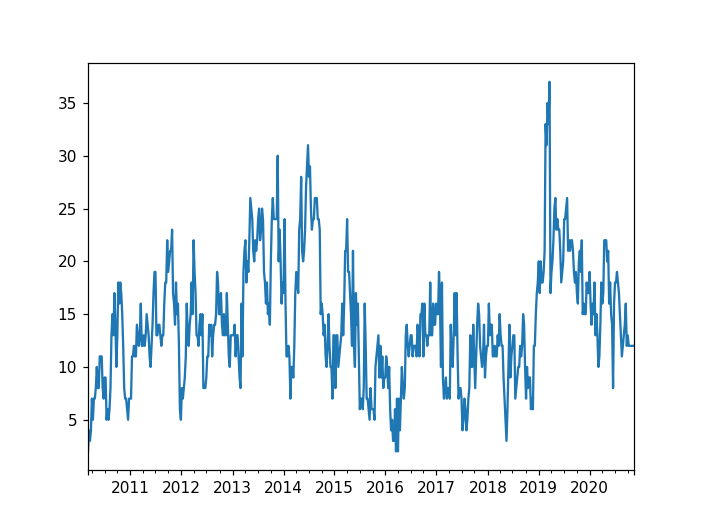

<AxesSubplot:>

In [64]:
ts3.plot()

In [95]:
pd.date_range(start='01-01-2020', end='02-01-2020', freq='W')[0]

TypeError: 'Timestamp' object is not subscriptable

In [93]:
pd.DatetimeIndex('2020')

TypeError: DatetimeIndex() must be called with a collection of some kind, '2020' was passed

In [41]:

# pd.Series(ts3[-1], index=[pd.to_datetime(date.today()).to_numpy()])

2020-11-10    12.0
dtype: float64

In [44]:
# from datetime import date
# #create time series for break_data
# ts3 = pd.Series(break_data['Taxa de Quebra'].values, index=break_data.index.get_level_values(0))
# #insert last datapoint as today, replicating last known value
# ts3 = ts3.append(pd.Series(ts3[-1], index=[pd.to_datetime(date.today()).to_numpy()]))
# # sample per week (get last value)
# ts3 = ts3.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
# xo3 = ts3.index
# yo3 = ts3.values

1053

In [60]:
import copy
#copy total active equipment and subtract break_rate time series to check if it equals available_equips
xo4 = copy.deepcopy(xo1)
yo4 = copy.deepcopy(yo1)
yo4[len(xo4)-len(xo3):] -= yo3

In [61]:
print(xo3[0],xo3[-1])
print(xo1[1053],xo1[-1])

2010-03-07 00:00:00 2020-11-15 00:00:00
2010-03-07 00:00:00 2020-11-15 00:00:00


In [23]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


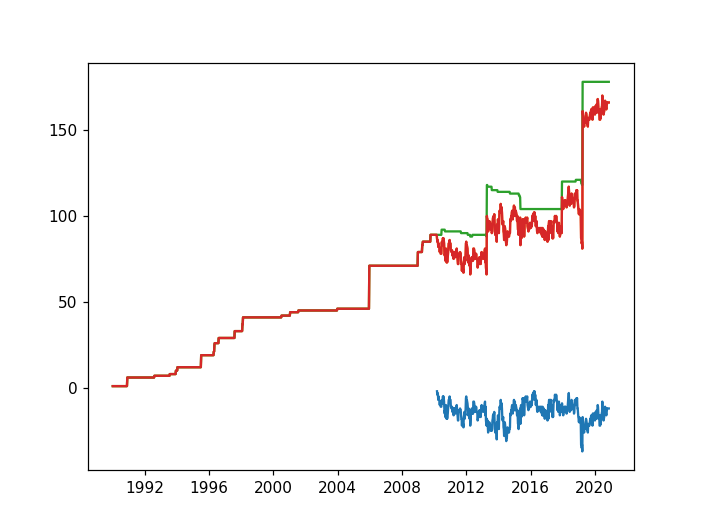

In [62]:
import matplotlib.pyplot as plt
# plt.plot(break_data.index.get_level_values(0), -break_data['Taxa de Quebra']+87)
# break_rate (inverted)
plt.plot(xo3,-yo3)
# available equipments (active - broken)
plt.plot(xo2,yo2)
# active equipment
plt.plot(xo1,yo1)
# calculated available equipment (active - break_rate)
plt.plot(xo4,yo4)

In [12]:
break_data['Taxa de Quebra']

Data                     Núm. O.S.
2010-03-02 13:54:11.000  10.3038       1
2010-03-02 13:57:31.000  10.3039       2
2010-03-04 13:54:11.000  10.3038       1
2010-03-05 16:02:36.000  10.3251       2
2010-03-08 13:40:51.000  10.3276       3
                                      ..
2020-09-30 08:52:43.499  20.3164      16
2020-10-01 13:51:52.101  20.3162      15
2020-10-01 13:52:20.912  20.3163      14
2020-10-01 13:52:43.499  20.3164      13
2020-10-05 08:36:01.864  20.3151      12
Name: Taxa de Quebra, Length: 5050, dtype: int32

In [63]:
# d = {xo1.to_frame()], 'Ativo': [yo1]}#, 'Data2': [xo2.to_frame()], 'Disponivel': [yo2]}
df = pd.DataFrame(data=xo1.to_frame(name='Data1'))

In [64]:
df.loc[:,'Ativo'] = yo1
df.loc[:,'Data2'] = xo2
df.loc[:,'Disponivel'] = yo2

In [65]:
df

,Data1,Ativo,Data2,Disponivel
1989-12-31,1989-12-31,1.0,1989-12-31,1.0
1990-01-07,1990-01-07,1.0,1990-01-07,1.0
1990-01-14,1990-01-14,1.0,1990-01-14,1.0
1990-01-21,1990-01-21,1.0,1990-01-21,1.0
1990-01-28,1990-01-28,1.0,1990-01-28,1.0
...,...,...,...,...
2020-10-18,2020-10-18,178.0,2020-10-18,166.0
2020-10-25,2020-10-25,178.0,2020-10-25,166.0
2020-11-01,2020-11-01,178.0,2020-11-01,166.0
2020-11-08,2020-11-08,178.0,2020-11-08,166.0


In [22]:
Fruits = {'a': "Apple", 'b':"Banana", 'c':"Carrot"}

In [56]:
pd.to_datetime(np.array([2012,2013]),format='%Y')

DatetimeIndex(['2012-01-01', '2013-01-01'], dtype='datetime64[ns]', freq=None)

In [26]:
xo

DatetimeIndex([       '1971-11-30 00:00:00',        '1971-11-30 00:00:00',
                      '1972-08-04 00:00:00',        '1979-06-18 00:00:00',
                      '1979-06-18 00:00:00',        '1979-12-08 00:00:00',
                      '1979-12-08 00:00:00',        '1992-07-14 00:00:00',
                      '1992-07-14 00:00:00',        '1993-09-01 00:00:00',
               ...
               '2020-06-30 15:08:15.861000', '2020-06-30 15:22:12.001000',
               '2020-07-16 18:36:45.881000', '2020-07-21 15:36:45.881000',
               '2020-08-20 15:30:53.849000', '2020-09-11 12:29:02.977000',
               '2020-09-15 15:29:02.977000', '2020-09-27 06:36:58.267000',
               '2020-10-05 08:35:33.302000',        '2020-11-05 00:00:00'],
              dtype='datetime64[ns]', length=235, freq=None)

In [21]:
# # create a dummy time series for 5 dummy stock tickers
# dates = pd.date_range(start='20180101', end='20181231')
# n = len(dates)
# tickers = list('ABCDE')
# prices = pd.DataFrame(np.random.randn(n, 5).cumsum(axis=0), columns=tickers)

# # create two dropdown menus for X and Y attributes of scatter
# x_dropdown = widgets.Dropdown(description='X', options=tickers, value='A')
# y_dropdown = widgets.Dropdown(description='Y', options=tickers, value='B')

# # create figure for plotting the scatter
# x_ticker = x_dropdown.value
# y_ticker = y_dropdown.value

# # set up fig_margin to allow space to display color bar
# fig_margin = dict(top=20, bottom=40, left=60, right=80)
# fig3 = plt.figure(animation_duration=1000, fig_margin=fig_margin)

# # custom axis options for color data
# axes_options = {'color': {'tick_format': '%m/%y', 
#                           'side': 'right',
#                           'num_ticks': 5}}
# scatter = bqplt.scatter(x=prices[x_ticker], 
#                       y=prices[y_ticker],
#                       color=dates, # represent chronology using color scale
#                       stroke='black',
#                       colors=['red'],
#                       default_size=32,
#                       axes_options=axes_options)
# bqplt.xlabel(x_ticker)
# bqplt.ylabel(y_ticker)

# # 1. create a callback which updates the plot when dropdown item is selected
# def update_scatter(*args):
#     x_ticker = x_dropdown.value
#     y_ticker = y_dropdown.value
    
#     # update the x and y attributes of the mark by selecting
#     # the column from the price data frame
#     with scatter.hold_sync():
#         scatter.x = prices[x_ticker]
#         scatter.y = prices[y_ticker]
    
#     # update the title of the figure
#     bqplt.xlabel(x_ticker)
#     bqplt.ylabel(y_ticker)

# # 2. register the callback by using the 'observe' method
# x_dropdown.observe(update_scatter, 'value')
# y_dropdown.observe(update_scatter, 'value')

# # stack the dropdown and fig widgets using VBox
# widgets.VBox([widgets.HBox([x_dropdown, y_dropdown]), fig3])

LINKS: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Linking-Widgets
        aCHO QUE TEM  q por um observe pra atualizar algo na figura (interaction por exemplo)
        https://traitlets.readthedocs.io/en/stable/utils.html

            

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [84]:
decomp = seasonal_decompose(ts3,period=52)

<IPython.core.display.Javascript object>


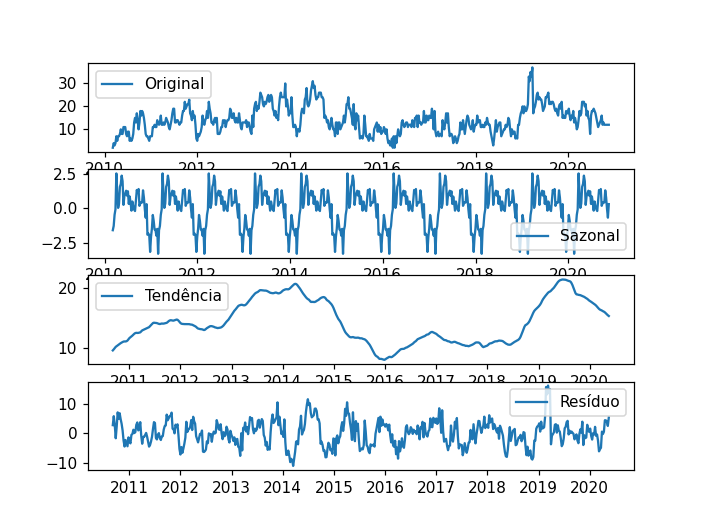

In [85]:
fig, ax = plt.subplots(4,1)
ax[0].plot(ts3.index.get_level_values(0),ts3,label='Original')
ax[0].legend()
ax[1].plot(ts3.index.get_level_values(0),decomp.seasonal,label='Sazonal')
ax[1].legend()
ax[2].plot(ts3.index.get_level_values(0),decomp.trend,label='Tendência')
ax[2].legend()
ax[3].plot(ts3.index.get_level_values(0),decomp.resid,label='Resíduo')
ax[3].legend()

## Find best arima parameters with autoarima

In [65]:
from pmdarima.arima import auto_arima

Z:\anaconda3\envs\GETS_env3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Z:\anaconda3\envs\GETS_env3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [66]:
modelo_auto = auto_arima(ts3, m=7, trace=False)

In [103]:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  559
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1376.729
Date:                Wed, 11 Nov 2020   AIC                           2761.458
Time:                        09:49:02   BIC                           2778.762
Sample:                             0   HQIC                          2768.215
                                - 559                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1470      0.267      4.302      0.000       0.625       1.670
ar.L1          0.9172      0.017     53.599      0.000       0.884       0.951
ma.L1         -0.1943      0.047     -4.109      0.000      -0.287      -0.102
sigma2         8.0454      0.348     23.123      0.000       7.363       8.727
===================================================================================
Ljung-Box (Q):                       32.94   Jarque-Bera (JB):               176.04
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
proximos12 = modelo_auto.predict(n_periods=12)

<IPython.core.display.Javascript object>


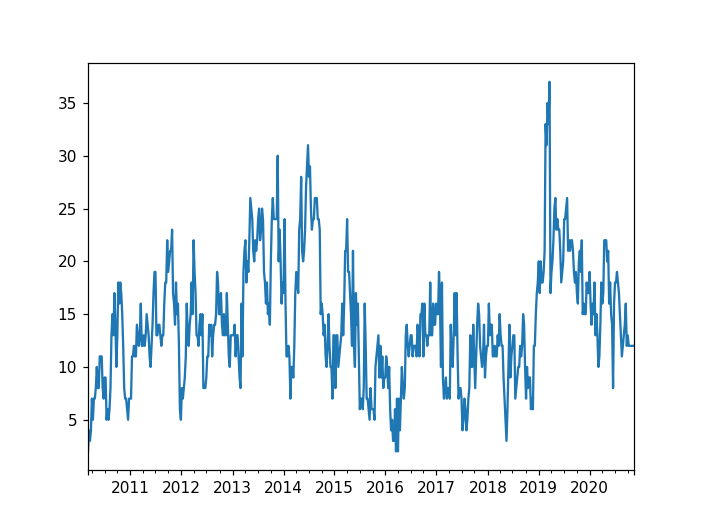

<AxesSubplot:>

In [70]:
ts3.plot()
# proximos12

## Apply arima to data

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
ts3_train = ts3[ts3.index<'2020']

<IPython.core.display.Javascript object>


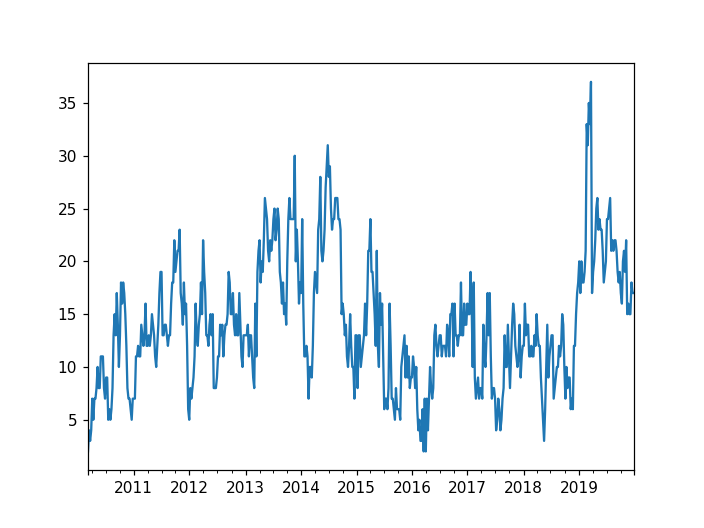

<AxesSubplot:>

In [18]:
ts3_train.plot()

In [19]:
model = ARIMA(ts3_train, order=(1,0,1))

In [20]:
model_fit = model.fit()

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  513
Model:                     ARMA(1, 1)   Log Likelihood               -1268.917
Method:                       css-mle   S.D. of innovations              2.867
Date:                Wed, 11 Nov 2020   AIC                           2545.835
Time:                        13:37:09   BIC                           2562.796
Sample:                    03-07-2010   HQIC                          2552.483
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8312      1.259     10.983      0.000      11.363      16.300
ar.L1.y        0.9211      0.020     47.183      0.000       0.883       0.959
ma.L1.y       -0.1982      0.048     -4.121      0.000      -0.292      -0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0857           +0.0000j            1.0857            0.0000
MA.1            5.0467           +0.0000j            5.0467            0.0000
-----------------------------------------------------------------------------
"""

<IPython.core.display.Javascript object>


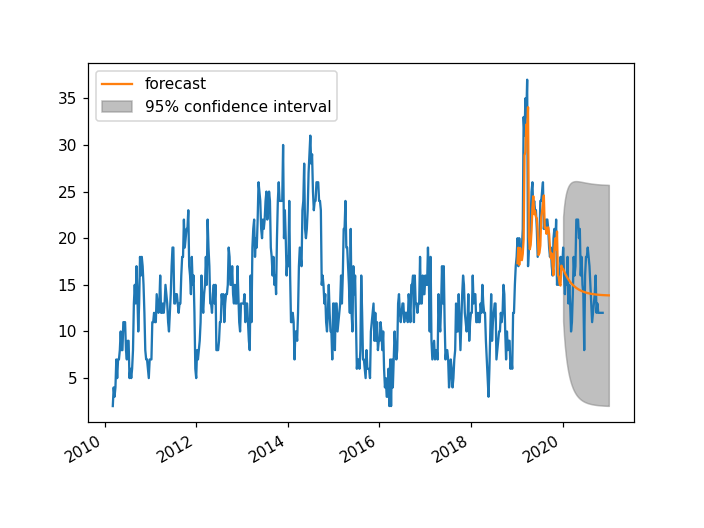

In [24]:
fig, ax = plt.subplots()
ax.plot(ts3.index,ts3.values)
fig = model_fit.plot_predict('2019', '2021', dynamic=False, ax=ax,plot_insample=False)

In [47]:
pred = model_fit.predict('2019', '2021', dynamic=False)

In [48]:
pred

2019-01-06    17.317700
2019-01-13    18.981783
2019-01-20    17.142674
2019-01-27    18.947101
2019-02-03    17.858751
                ...    
2020-12-06    13.886749
2020-12-13    13.882364
2020-12-20    13.878325
2020-12-27    13.874605
2021-01-03    13.871179
Freq: W-SUN, Length: 105, dtype: float64

In [49]:
idx1 = np.argwhere(xo1==pred.index[0])[0][0]
idx2 = np.argwhere(xo1[-1]==pred.index)[0][0]
print(idx1, idx2)

# pred.values[:idx2] = 

1514 97


In [73]:
np.array([[pred.values[idx2], pred.values[idx2]]])

array([[164.09771165, 164.09771165]])

<IPython.core.display.Javascript object>


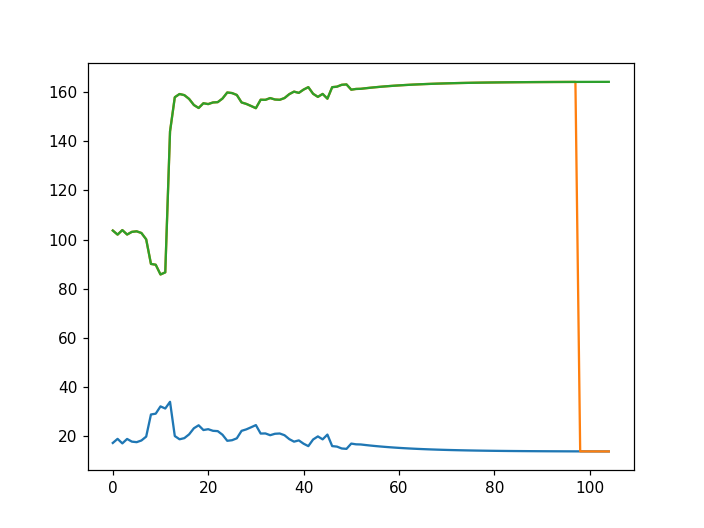

In [50]:
plt.plot(pred.values)
pred.values[:idx2+1] = yo1[idx1:] - pred.values[:idx2+1]
plt.plot(pred.values)
pred.values[idx2+1:] = yo1[-1] - pred.values[idx2+1:]
plt.plot(pred.values)

In [34]:
xo1[idx1:]

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24',
               '2019-03-31', '2019-04-07', '2019-04-14', '2019-04-21',
               '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
               '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16',
               '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
               '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
               '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08',
               '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-06',
               '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03',
               '2019-11-10', '2019-11-17', '2019-11-24', '2019-12-01',
               '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29',
               '2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
      

In [62]:
pd.date_range(start=pred.index[idx2+1], end=pred.index[-1], freq='W')

DatetimeIndex(['2020-11-22', '2020-11-29', '2020-12-06', '2020-12-13',
               '2020-12-20', '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', freq='W-SUN')

In [ ]:
xo4 = copy.deepcopy(xo1)
yo4 = copy.deepcopy(yo1)
yo4[len(xo4)-len(xo3):] -= yo3

In [58]:
pred.index

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10',
               ...
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13', '2020-12-20',
               '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', length=105, freq='W-SUN')

In [54]:
pred.index[idx2]

Timestamp('2020-11-22 00:00:00', freq='W-SUN')

<IPython.core.display.Javascript object>


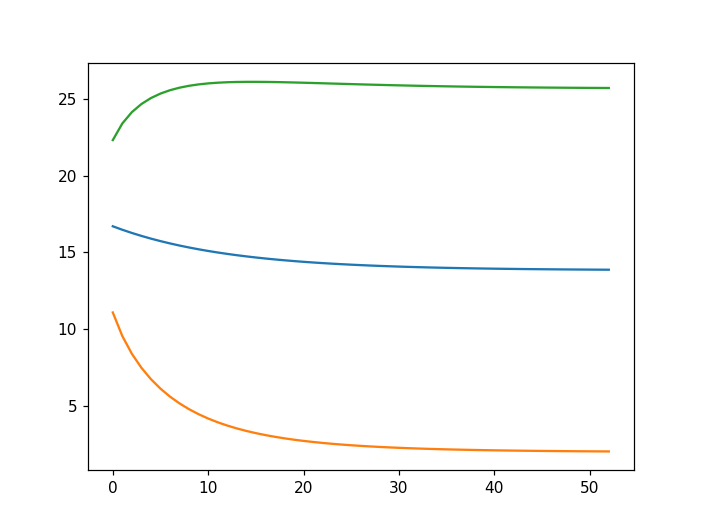

In [112]:
plt.plot(model_fit.forecast(53)[0])
plt.plot(model_fit.forecast(53)[2])

In [113]:
model_fit.conf_int()

,0,1
const,11.362848,16.299502
ar.L1.y,0.882839,0.959363
ma.L1.y,-0.292392,-0.103910


<IPython.core.display.Javascript object>


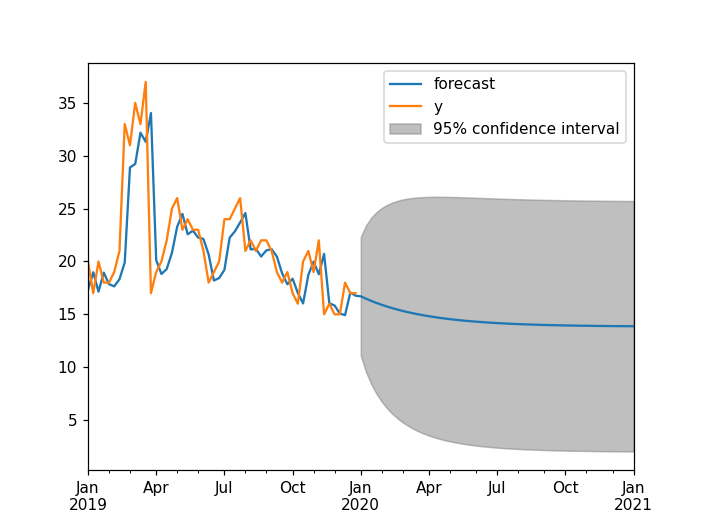

<IPython.core.display.Javascript object>


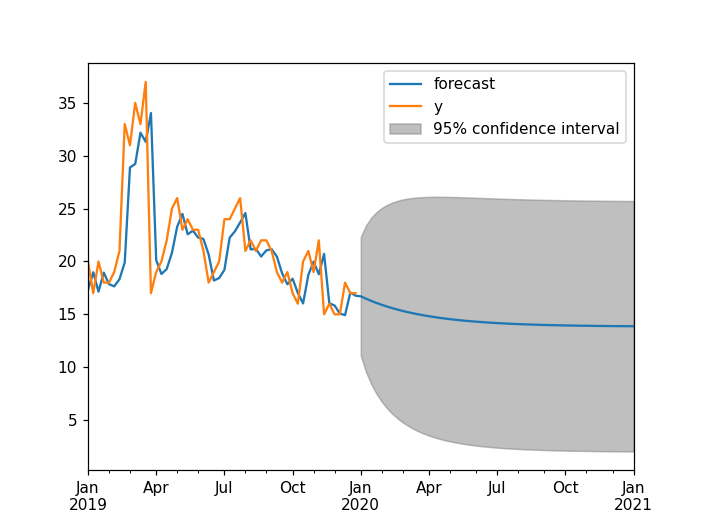

In [93]:
model_fit.plot_predict('2019','2021')

In [72]:
# modelo = ARIMA(ts1_monthly, order=(1,1,2),freq=ts1.index.inferred_freq)

modelo = ARIMA(ts3, order=(1,0,1))

In [73]:
modelo_treinado = modelo.fit()

In [74]:
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  559
Model:                     ARMA(1, 1)   Log Likelihood               -1376.729
Method:                       css-mle   S.D. of innovations              2.837
Date:                Tue, 10 Nov 2020   AIC                           2761.458
Time:                        19:28:17   BIC                           2778.762
Sample:                    03-07-2010   HQIC                          2768.215
                         - 11-15-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8557      1.147     12.076      0.000      11.607      16.104
ar.L1.y        0.9172      0.019     47.725      0.000       0.880       0.955
ma.L1.y       -0.1942      0.046     -4.216      0.000      -0.285      -0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0903           +0.0000j            1.0903            0.0000
MA.1            5.1480           +0.0000j            5.1480            0.0000
-----------------------------------------------------------------------------
"""

In [75]:
a = modelo_treinado.forecast(steps=12)

<IPython.core.display.Javascript object>


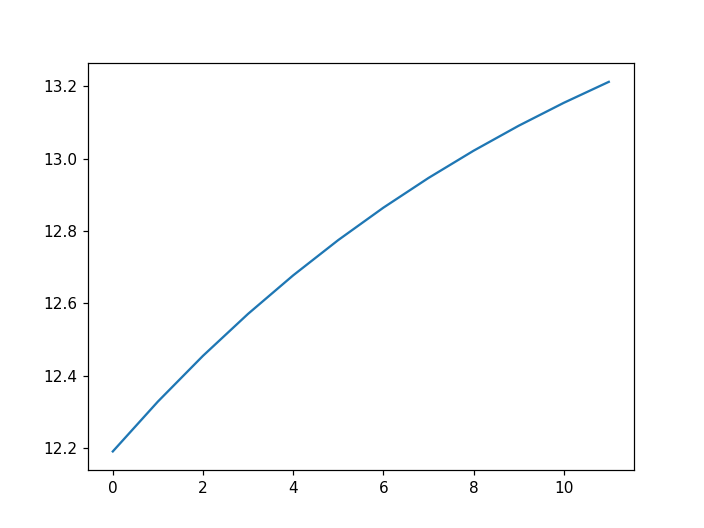

In [76]:
plt.plot(a[0])

<IPython.core.display.Javascript object>


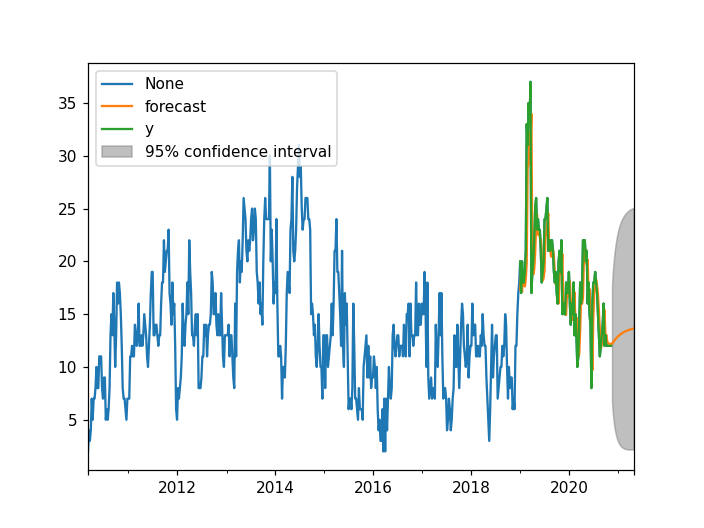

<IPython.core.display.Javascript object>


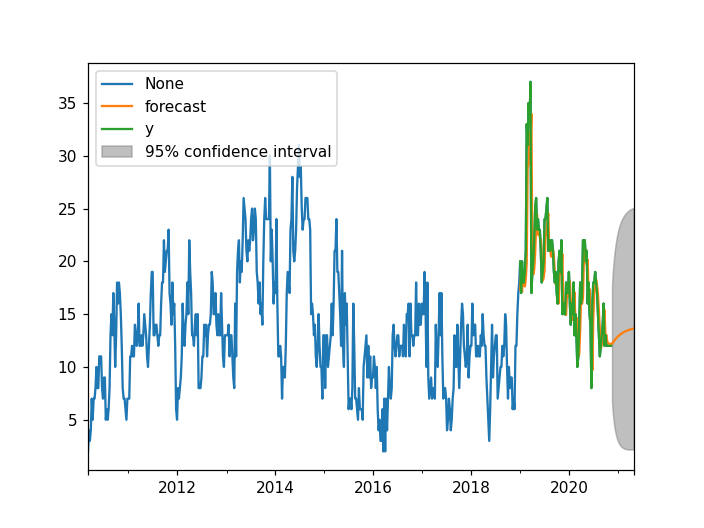

In [79]:
ax1 = ts3.plot()
modelo_treinado.plot_predict('2019','05-2021', ax=ax1, plot_insample=True)